In [1]:
# Import required libraries.

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import plot_model #for model visualization

In [2]:
# Load the dataset.

data_dir = "/content/sample_data/data/"


with_mask_dir = os.path.join(data_dir, "with_mask")
without_mask_dir = os.path.join(data_dir, "without_mask")


In [3]:
with_mask = os.listdir(with_mask_dir)[:5]
without_mask = os.listdir(without_mask_dir)[:5]

In [4]:
type(with_mask)

list

### Visulize first 5 img from both with and without mask datasets

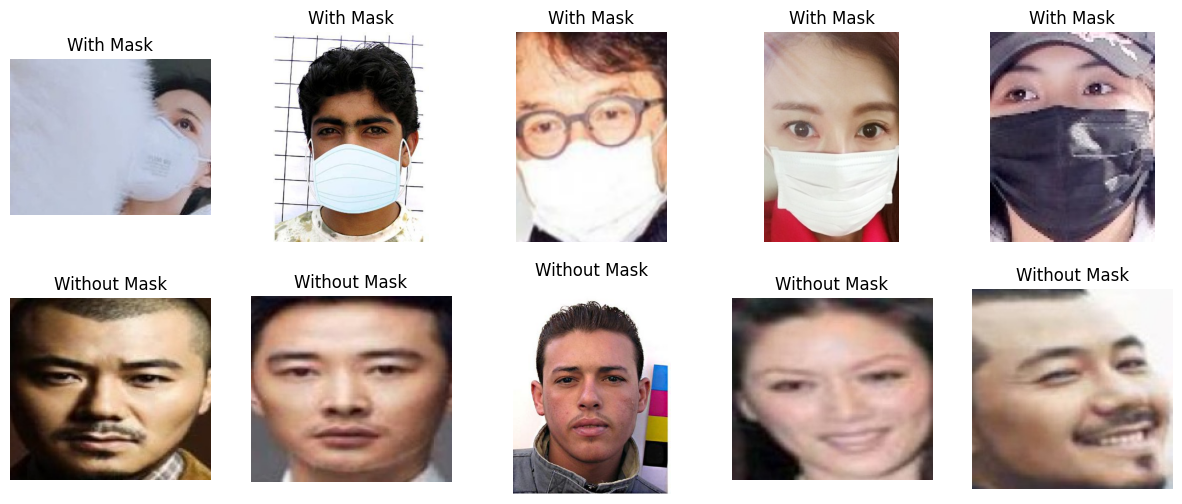

In [5]:

# Plot the first 5 images from the "with_mask" class
plt.figure(figsize=(15, 6))
for i, file in enumerate(with_mask, 1):
    img_path = os.path.join(with_mask_dir, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV uses BGR)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title('With Mask')

# Plot the first 5 images from the "without_mask" class
for i, file in enumerate(without_mask, 1):
    img_path = os.path.join(without_mask_dir, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV uses BGR)
    plt.subplot(2, 5, i + 5)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Without Mask')

plt.show()

### data preprocessing.

In [6]:
data_with_mask= os.listdir(with_mask_dir)
data_without_mask= os.listdir(without_mask_dir)

In [7]:
len(data_with_mask)

1467

In [8]:
len(data_without_mask)

1357

##### We can see that we have balaced dataset here. -  no need for sampling

### annotate the data with labels

In [9]:
## Do lebleing for withmask - 1, withoutmast -0.

with_mask_labels = [1]*len(data_with_mask)
print(f"With Mask labels" ,with_mask_labels[0:10])

without_mask_labels = [0]*len(data_without_mask)
print(f"Without Mask Labels", without_mask_labels[0:10])

With Mask labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Without Mask Labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
Labels = with_mask_labels + without_mask_labels
print(f"Labels", Labels[0:10])
print(f"Labels", Labels[-10:])

Labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Resize images and convert to numpy array

In [11]:
#resize images and convert to numpy array
import os
from PIL import Image

images = []
def load_images_from_folder(folder):

    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        img = img.resize((128,128))
        img = img.convert('RGB')
        images.append(np.array(img))
    return images

with_mask_images = load_images_from_folder('/content/sample_data/data/with_mask')
without_mask_images = load_images_from_folder('/content/sample_data/data/without_mask')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
len(images)

2824

In [13]:
images[0].shape

(128, 128, 3)

In [14]:
images[100].shape

(128, 128, 3)

In [15]:
X = np.array(images)
y = np.array(Labels)

In [16]:
X.shape

(2824, 128, 128, 3)

In [17]:
y.shape

(2824,)

### Train Test Split

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
X_train.shape

(2259, 128, 128, 3)

In [20]:
X_test.shape


(565, 128, 128, 3)

In [21]:
y_train.shape

(2259,)

In [22]:
y_test.shape

(565,)

### Scalle the data.


In [23]:
X_train = X_train/255

X_test = X_test/255

In [24]:
# Save each model performance

model_dict ={}

In [25]:
print(model_dict)

{}


In [26]:
# Function to build the model
def build_model(base_model):
    for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
        layer.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(rate=0.3),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(rate=0.3),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(rate=0.3),
        Dense(2, activation='sigmoid')
    ])

    model.compile(Adamax(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [27]:
# Function to train the model
def train_model(model, base_model_name, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    start_time = time.time()

    # Manually split the data into training and validation sets
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Train the model with early stopping and data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

    end_time = time.time()
    training_time = end_time - start_time

    # Get the final training and validation accuracy
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    # Get the final training and validation loss
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Store the model information in the global dictionary
    model_dict[base_model_name] = {
        'Model Name': base_model_name,
        'Training Time (seconds)': training_time,
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Train Loss': train_loss,
        'Validation Loss': val_loss
    }

    # Save the model
    model.save(f"{base_model_name}_model.h5")
    print(f"Model {base_model_name} saved successfully.")



In [28]:
# Function to save the model results
def save_model_results(model_dict, file_name='model_comparison.json'):
    with open(file_name, 'w') as f:
        json.dump(model_dict, f)
    print(f"Model results saved to {file_name}")



In [29]:
# Function to load model results
def load_model_results(file_name='model_comparison.json'):
    with open(file_name, 'r') as f:
        model_dict = json.load(f)
    return model_dict

# Function to plot training time comparison
def plot_training_time_comparison(model_dict):
    model_names = list(model_dict.keys())
    training_times = [model_dict[model]['Training Time (seconds)'] for model in model_dict]

    plt.figure(figsize=(10, 6))
    plt.barh(model_names, training_times, color='skyblue')
    plt.xlabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.show()

In [30]:

# Function to plot accuracy comparison
def plot_accuracy_comparison(model_dict):
    model_names = list(model_dict.keys())
    train_accuracies = [model_dict[model]['Train Accuracy'] for model in model_dict]
    val_accuracies = [model_dict[model]['Validation Accuracy'] for model in model_dict]

    plt.figure(figsize=(10, 6))
    plt.plot(model_names, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(model_names, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()
    plt.show()


# Function to plot loss comparison
def plot_loss_comparison(model_dict):
    model_names = list(model_dict.keys())
    train_losses = [model_dict[model]['Train Loss'] for model in model_dict]
    val_losses = [model_dict[model]['Validation Loss'] for model in model_dict]

    plt.figure(figsize=(10, 6))
    plt.plot(model_names, train_losses, label='Train Loss', marker='o')
    plt.plot(model_names, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Model')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()
    plt.show()

###  Main function

Training model: ResNet152V2
234545216/234545216 [==============================] - 2s 0us/step
Epoch 1/25
64/64 [==============================] - 119s 449ms/step - loss: 7.0810 - accuracy: 0.7993 - val_loss: 410.9570 - val_accuracy: 0.5531
Epoch 2/25
64/64 [==============================] - 20s 317ms/step - loss: 5.9830 - accuracy: 0.9213 - val_loss: 7.0051 - val_accuracy: 0.8850
Epoch 3/25
64/64 [==============================] - 21s 318ms/step - loss: 5.2606 - accuracy: 0.9484 - val_loss: 4.9248 - val_accuracy: 0.9690
Epoch 4/25
64/64 [==============================] - 21s 324ms/step - loss: 4.6320 - accuracy: 0.9636 - val_loss: 4.3569 - val_accuracy: 0.9735
Epoch 5/25
64/64 [==============================] - 21s 328ms/step - loss: 4.1420 - accuracy: 0.9680 - val_loss: 3.8535 - val_accuracy: 0.9823
Epoch 6/25
64/64 [==============================] - 21s 325ms/step - loss: 3.6891 - accuracy: 0.9720 - val_loss: 3.4728 - val_accuracy: 0.9735
Epoch 7/25
64/64 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model ResNet152V2 saved successfully.
Training model: Xception
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/25
64/64 [==============================] - 46s 299ms/step - loss: 7.5105 - accuracy: 0.8657 - val_loss: 6.6377 - val_accuracy: 0.8761
Epoch 2/25
64/64 [==============================] - 14s 219ms/step - loss: 5.5848 - accuracy: 0.9739 - val_loss: 5.1632 - val_accuracy: 0.9469
Epoch 3/25
64/64 [==============================] - 14s 222ms/step - loss: 4.4316 - accuracy: 0.9803 - val_loss: 4.1640 - val_accuracy: 1.0000
Epoch 4/25
64/64 [==============================] - 14s 214ms/step - loss: 3.6266 - accuracy: 0.9867 - val_loss: 3.3831 - val_accuracy: 0.9956
Epoch 5/25
64/64 [==============================] - 14s 217ms/step - loss: 2.9964 - accuracy: 0.9961 - val_loss: 2.8047 - val_accuracy: 0.9956
Epoch 6/25
64/64 [==============================] - 14s 218ms/step - loss: 2.5428 - accuracy: 0.9887 - val_loss: 2.4066 - val_accuracy: 0.9912
Epoch 7/25
64/

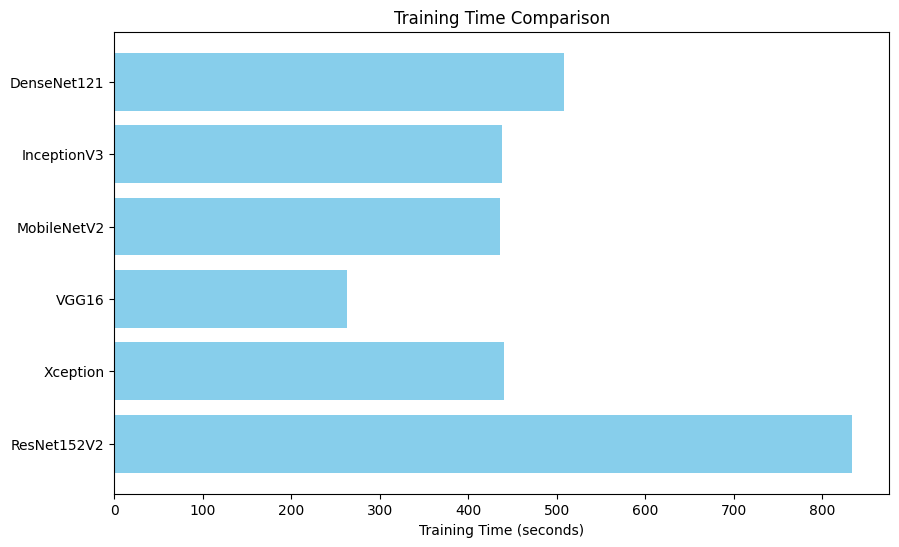

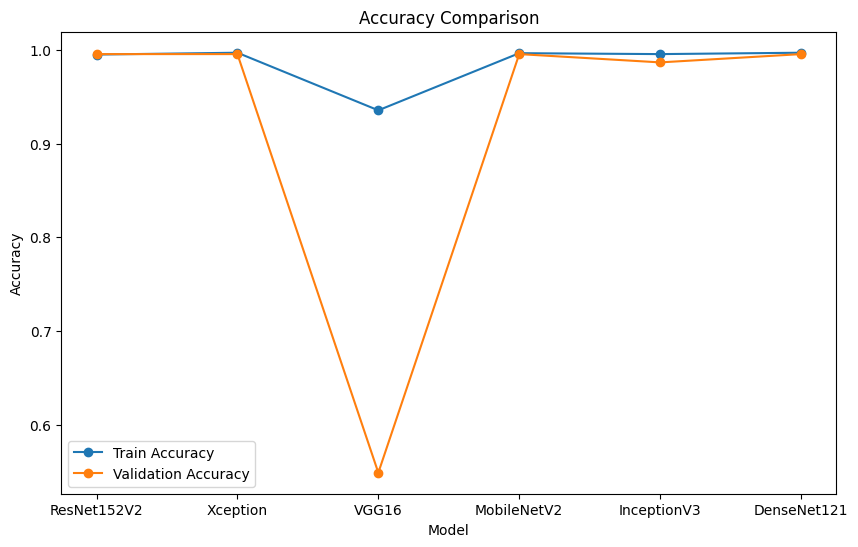

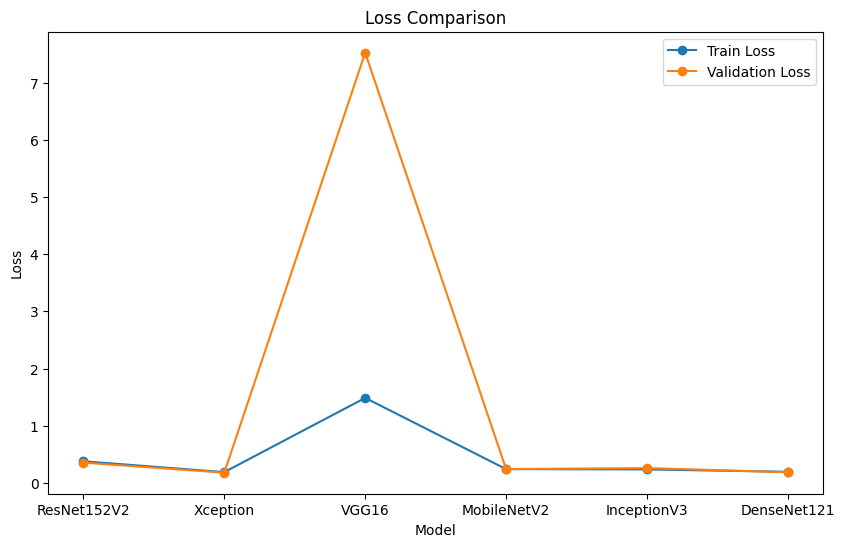

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import json
import time
import matplotlib.pyplot as plt


# List of models to be evaluated
model_list = [
    ("ResNet152V2", tf.keras.applications.ResNet152V2),
    ("Xception", tf.keras.applications.Xception),
    ("VGG16", tf.keras.applications.VGG16),
    ("MobileNetV2", tf.keras.applications.MobileNetV2),
    ("InceptionV3", tf.keras.applications.InceptionV3),
    ("DenseNet121", tf.keras.applications.DenseNet121)
]

# Image size and channels
image_size = (128, 128)
channels = 3
image_shape = (image_size[0], image_size[1], channels)

# Global dictionary to store model results
model_dict = {}

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Loop through each model, build, train, and save the results
for model_name, model_class in model_list:
    print(f"Training model: {model_name}")
    base_model = model_class(include_top=False, weights="imagenet", input_shape=image_shape)
    model = build_model(base_model)
    train_model(model, model_name, X_train, y_train)

# Save the model results
save_model_results(model_dict)

# Load and plot the results
model_dict = load_model_results('model_comparison.json')
plot_training_time_comparison(model_dict)
plot_accuracy_comparison(model_dict)
plot_loss_comparison(model_dict)


In [41]:
#Classification Report

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

18/18 [==============================] - 1s 57ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       274
           1       1.00      0.99      0.99       291

    accuracy                           0.99       565
   macro avg       0.99      0.99      0.99       565
weighted avg       0.99      0.99      0.99       565



# Observations:-

### Based on the provided data, here are the insights to determine the best model for face mask detection:

## Model Performance Summary:
1. ResNet152V2
   - Training Time: 833.77 seconds
   - Train Accuracy: 99.51%
   - Validation Accuracy: 99.56%
   - Train Loss: 0.3790
   - Validation Loss: 0.3564

2. Xception
   - Training Time: 439.86 seconds
   - Train Accuracy: 99.70%
   - Validation Accuracy: 99.56%
   - Train Loss: 0.1894
   - Validation Loss: 0.1791

3. VGG16
   - Training Time: 262.43 seconds
   - Train Accuracy: 93.56%
   - Validation Accuracy: 54.87%
   - Train Loss: 1.4872
   - Validation Loss: 7.5226

4. MobileNetV2
   - Training Time: 435.51 seconds
   - Train Accuracy: 99.66%
   - Validation Accuracy: 99.56%
   - Train Loss: 0.2420
   - Validation Loss: 0.2428

5. InceptionV3
   - Training Time: 438.11 seconds
   - Train Accuracy: 99.56%
   - Validation Accuracy: 98.67%
   - Train Loss: 0.2369
   - Validation Loss: 0.2597

6. DenseNet121
   - Training Time: 508.63 seconds
   - Train Accuracy: 99.70%
   - Validation Accuracy: 99.56%
   - Train Loss: 0.1947
   - Validation Loss: 0.1886


## Insights:

1. Accuracy: Accuracy is crucial for a face mask detection model. All models except VGG16 have very high train and validation accuracies above 99%. VGG16, on the other hand, has a significantly lower validation accuracy of approximately 54.87%.

2. Training Time: The time taken to train the model is also an important factor, especially for resource and time management. VGG16 has the shortest training time (262 seconds), but its poor accuracy makes it unsuitable despite the speed. ResNet152V2 has the longest training time (834 seconds).

3. Loss: Both train and validation loss should be low for a good model. Xception, DenseNet121, and MobileNetV2 have the lowest train and validation losses, indicating better model performance and reliability.

4. Consistency: A good model should have consistent performance across training and validation datasets. Models like Xception, MobileNetV2, and DenseNet121 show consistent high accuracy and low loss in both training and validation.

## Conclusion:

The best model for face mask detection based on the provided metrics is MobileNetV2 due to its high validation accuracy (99.56%), relatively low validation loss (0.24), and efficient training time (435 seconds). This model balances performance and training efficiency effectively, making it suitable for face mask detection tasks.


## Do some testing.

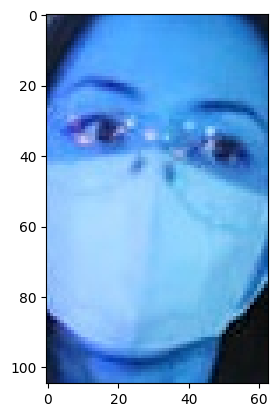

1/1 [==============================] - 1s 1s/step
[[0.0173472  0.97700727]]
1
The person in the image is wearing a mask


In [38]:
from tensorflow.keras.models import load_model

input_image_path = '/content/sample_data/data/with_mask/with_mask_200.jpg'

# Load the model
model = load_model('/content/MobileNetV2_model.h5')

input_image = cv2.imread(input_image_path)

plt.imshow(input_image)
plt.show()

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 1:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

# Do Tesing on realtime using MTCNN

In [39]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00


In [40]:
from google.colab import output
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from mtcnn import MTCNN
from IPython.display import display, HTML

# Define HTML code for the button
grant_camera_access_button = """
<script>
function grantCameraAccess() {
  google.colab.kernel.invokeFunction('notebook.run_when_granted', [], {});
}
</script>
<button onclick="grantCameraAccess()">Grant Camera Access</button>
"""

# Display the button
display(HTML(grant_camera_access_button))

# Define a function to be called when camera access is granted
def run_when_granted():
    try:
        # Load the trained model
        model = load_model('/content/MobileNetV2_model.h5')
        print("Model loaded successfully.")

        # Initialize MTCNN for face detection
        detector = MTCNN()
        print("MTCNN initialized successfully.")

        # Initialize the webcam
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Failed to open camera.")
            return

        print("Camera opened successfully.")

        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to capture frame.")
                break

            # Detect faces in the frame using MTCNN
            faces = detector.detect_faces(frame)

            for face in faces:
                # Get the bounding box coordinates
                x, y, width, height = face['box']
                x2, y2 = x + width, y + height

                # Extract the face region
                face_region = frame[y:y2, x:x2]

                # Preprocess the face region
                face_resized = cv2.resize(face_region, (128, 128))  # Resize to match the input shape of the model
                face_normalized = face_resized / 255.0              # Normalize the pixel values
                face_reshaped = np.reshape(face_normalized, (1, 128, 128, 3))  # Reshape for the model input

                # Predict mask or no mask
                prediction = model.predict(face_reshaped)
                (mask, without_mask) = prediction[0]

                # Determine the class label and color
                label = "Mask" if mask > without_mask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

                # Display the label and bounding box rectangle on the output frame
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (x, y), (x2, y2), color, 2)

            # Display the resulting frame
            cv2.imshow('Face Mask Detection', frame)

            # Break the loop on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # When everything is done, release the capture
        cap.release()
        cv2.destroyAllWindows()

    except Exception as e:
        print("An error occurred:", e)

# Register the function to be called when camera access is granted
output.register_callback('notebook.run_when_granted', run_when_granted)


Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded successfully.
MTCNN initialized successfully.
Failed to open camera.
Model loaded suc